In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, roc_auc_score, confusion_matrix, fbeta_score
from sklearn.preprocessing import PolynomialFeatures

from lightgbm import LGBMClassifier

In [2]:
dataset = pd.read_csv("dataset.csv", sep=';')

In [3]:
# dataset.dtypes

In [4]:
dataset.shape

(99976, 43)

### Data exploration

We have a strongly imbalanced classification, and the class of interest is very rare.
The data has None values, but the modern algorithms can handle them effectively, so there is no need to decide how to fill them. Categorical values also can be given to the algorithms without encoding. Therefore, the data preprocessing was specific to the model and included just type conversion.

As it is the imbalanced case, the most important part is to choose a metric to evaluate the model's performance. I will look at the classificartion report with such metrics as precision, recall and F1 score. Also the confusion matrix will help to undertsand how model make predictions. The final choice of the metrics depends on the business's needs and costs. For example, if we know what type of error costs more, we can optimize the model in the correct way. As the class of interest is rare, I would suggest that false negatives error costs more and will use F2-measure to select the best model (it has the effect of lowering the importance of precision and increase the importance of recall).
Cross validation technique is used to evaluate the model (numbers of folds = 3). I was important to use Stratifyed methods to keep the correct class ratio. 

The model development was the following (the randon states are fixed everywhere to ensure the splits are the same):
1. Fit LighGBM classifier without any feature engineering, specifying the parameters responsible for class weights (tried setting is_unbalance=True and class_weight='balanced'). Validation set is used to prevent overfitting and the best model on validation is used. Got the F1 score 0.168 and 0.172 respectively.
2. Fit Catboost classifier without any feature engineering, specifying the parameters responsible for class weights. Validation set is used to prevent overfitting and the best model on validation is used. The F1 score was 0.116. I decided to use Catboost classifier as it is less tend to oveffit and I found its prediction behavour better than LightGBM classifier's
3. Models based on the decision trees find it harder to catch up nonlinear dependences, so I tried to create polynomial features for numerical fearures without Nans and fitting Catboost classifier on them. The score was 0.107 and from the confusion matrix it was seen that the model tends to predict positive class more but the recall was not better. I decided not to use polynomial features. 
4. There is a technique for oversampling, SMOTE, to balance out the data. I had to fill the nan values and use the version of SMOTE supporting categoricalfeatures. After that I fit Catboost model on them but without specification of classes weight. The F1 score was 0.137, but from the report and the confusion matrix it was obvious that the behavoiur of the model is not what we expect, there were much less correctly found elements from positive class.
5. The last step was tuning hyperparameters and I used hyperopt library (based on bayesian optimisation) to serach for the best params for Catboost model. 

As boosting models based on trees can perofrm feature selection, I didn't spend time on it.


There are techniques to deal with such datasets, but the final conclusion is that if it is possible to collect more data, or more features, then it is the best way. 

In [5]:
# Check that all uids are unique
len(dataset.uuid.unique()), dataset.shape 

(99976, (99976, 43))

In [6]:
# target distribution
dataset.default.value_counts(dropna=False)

0.0    88688
NaN    10000
1.0     1288
Name: default, dtype: int64

In [7]:
print(f'Fraction of positive elements: {round(1288/88688*100, 2)}%')

Fraction of positive elements: 1.45%


In [8]:
cat_features = ['account_status', 'account_worst_status_0_3m', 'account_worst_status_12_24m', 
                'account_worst_status_3_6m', 'account_worst_status_6_12m', 'merchant_category', 
                'merchant_group', 'name_in_email', 'status_last_archived_0_24m', 
                'status_2nd_last_archived_0_24m', 'status_3rd_last_archived_0_24m', 
                'status_max_archived_0_6_months', 'status_max_archived_0_12_months', 
                'status_max_archived_0_24_months', 'worst_status_active_inv', 'has_paid']

rest_features = ['account_amount_added_12_24m', 'account_days_in_dc_12_24m', 'account_days_in_rem_12_24m',
                 'account_days_in_term_12_24m', 'account_incoming_debt_vs_paid_0_24m', 'age', 
                 'avg_payment_span_0_12m', 'avg_payment_span_0_3m', 'max_paid_inv_0_12m', 'max_paid_inv_0_24m',
                 'num_active_div_by_paid_inv_0_12m', 'num_active_inv', 'num_arch_dc_0_12m', 'num_arch_dc_12_24m',
                 'num_arch_ok_0_12m', 'num_arch_ok_12_24m', 'num_arch_rem_0_12m',
                 'num_arch_written_off_0_12m', 'num_arch_written_off_12_24m', 'num_unpaid_bills',
                 'recovery_debt', 'sum_capital_paid_account_0_12m', 'sum_capital_paid_account_12_24m',
                 'sum_paid_inv_0_12m', 'time_hours']

In [9]:
for cat_feature in cat_features:
    dataset[cat_feature] = dataset[cat_feature].astype(str)
for feature in rest_features:
    dataset[feature] = dataset[feature].astype(float)

In [10]:
dataset.isna().sum()

uuid                                       0
default                                10000
account_amount_added_12_24m                0
account_days_in_dc_12_24m              11836
account_days_in_rem_12_24m             11836
account_days_in_term_12_24m            11836
account_incoming_debt_vs_paid_0_24m    59315
account_status                             0
account_worst_status_0_3m                  0
account_worst_status_12_24m                0
account_worst_status_3_6m                  0
account_worst_status_6_12m                 0
age                                        0
avg_payment_span_0_12m                 23836
avg_payment_span_0_3m                  49305
merchant_category                          0
merchant_group                             0
has_paid                                   0
max_paid_inv_0_12m                         0
max_paid_inv_0_24m                         0
name_in_email                              0
num_active_div_by_paid_inv_0_12m       22939
num_active

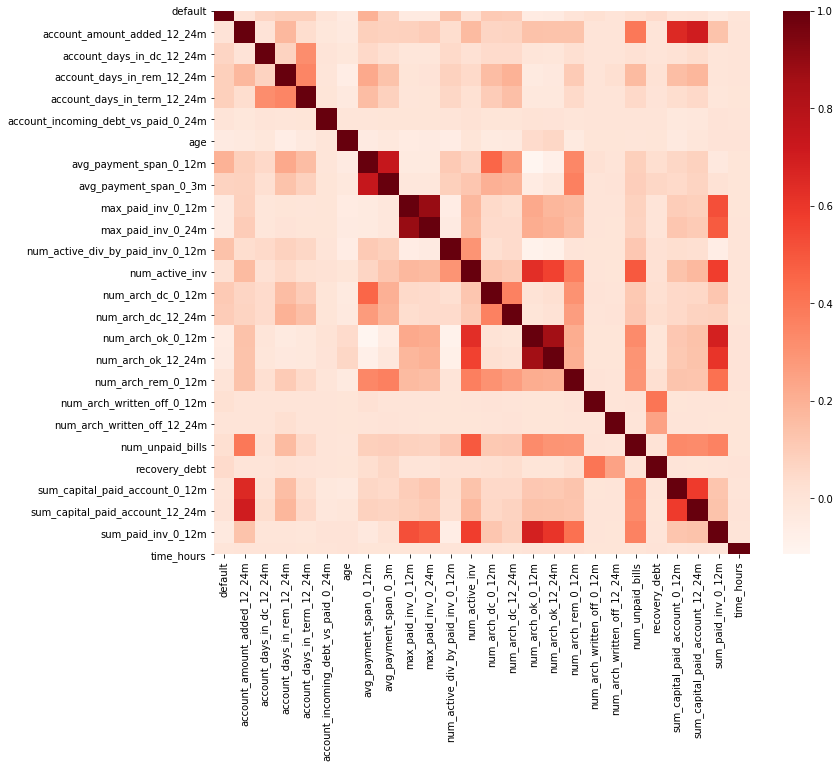

In [11]:
plt.figure(figsize=(12,10))
cor = dataset.drop(['uuid'], 1)[dataset.default.notnull()].corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

From the correaltion heatmap we see that there is no any feature highly correlated with the target

In [12]:
def stratified_cv(X, y, model, n=3):
    kfold = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)
    y_preds = []
    for train_ix, test_ix in kfold.split(X, y):
        train_X, test_X = X.iloc[train_ix], X.iloc[test_ix]
        train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
        val_X, test_X, val_y, test_y = train_test_split(test_X, test_y, 
                                                        test_size=0.5, stratify=test_y, random_state=42)
        if isinstance(model, LGBMClassifier):
            model.fit(train_X, train_y,
                      eval_set=(val_X, val_y),
                      early_stopping_rounds=30,
                      verbose=False)
#             print(fbeta_score(model.predict(train_X), train_y, beta=2.))
#             print(fbeta_score(model.predict(val_X), val_y, beta=2.))
        elif isinstance(model, CatBoostClassifier):
            model.fit(train_X, train_y,
                      cat_features=cat_features,
                      eval_set=(val_X, val_y),
                      verbose=False)
#             print(fbeta_score(model.predict(train_X), train_y, beta=2.))
#             print(fbeta_score(model.predict(val_X), val_y, beta=2.))
        else:
            print("The wrong model")
            return None
  
        y_preds.append((model.predict(test_X), test_y))
        
    return y_preds

## Catboost

In [13]:
dataset1 = dataset.copy()

In [14]:
inference_df = dataset1[dataset1.default.isnull()].copy()
train_df = dataset1[dataset1.default.notnull()].copy()

train_df['default'] = train_df['default'].astype(int)

X = train_df.drop(['uuid', 'default'], 1)
y = train_df.default

In [15]:
class_weight = [0.015, 0.985]

In [16]:
model = CatBoostClassifier(iterations=500, class_weights=class_weight, 
                           early_stopping_rounds=60)
y_preds_cb1 = stratified_cv(X, y, model)

In [17]:
print(np.mean([fbeta_score(*t, beta=2.) for t in y_preds_cb1]))

0.07306602001042418


In [18]:
for y_pred in y_preds_cb1:
    print(classification_report(*y_pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91     12318
           1       0.82      0.07      0.12      2678

    accuracy                           0.83     14996
   macro avg       0.82      0.53      0.51     14996
weighted avg       0.83      0.83      0.77     14996

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     11931
           1       0.79      0.06      0.10      3065

    accuracy                           0.80     14996
   macro avg       0.80      0.53      0.50     14996
weighted avg       0.80      0.80      0.73     14996

              precision    recall  f1-score   support

           0       0.82      1.00      0.90     12160
           1       0.77      0.06      0.11      2836

    accuracy                           0.82     14996
   macro avg       0.79      0.53      0.50     14996
weighted avg       0.81      0.82      0.75     14996



In [19]:
for y_pred in y_preds_cb1:
    print(confusion_matrix(*y_pred))

[[12279    39]
 [ 2503   175]]
[[11886    45]
 [ 2896   169]]
[[12110    50]
 [ 2671   165]]


### LightGBM

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
dataset2 = dataset.copy()

In [22]:
for cat_feature in cat_features:
    dataset2[cat_feature] = dataset2[cat_feature].astype('category')

In [23]:
inference_df = dataset2[dataset2.default.isnull()].copy()
train_df = dataset2[dataset2.default.notnull()].copy()

train_df['default'] = train_df['default'].astype(int)

X = train_df.drop(['uuid', 'default'], 1)
y = train_df.default

In [24]:
model = LGBMClassifier(objective='binary', is_unbalance=True, is_training_metric=True)
y_preds_lgbm1 = stratified_cv(X, y, model)

In [25]:
print(np.mean([fbeta_score(*t, beta=2.) for t in y_preds_lgbm1]))

0.11291556515766754


In [26]:
for y_pred in y_preds_lgbm1:
    print(classification_report(*y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     13602
           1       0.56      0.09      0.15      1394

    accuracy                           0.91     14996
   macro avg       0.74      0.54      0.55     14996
weighted avg       0.88      0.91      0.88     14996

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     13655
           1       0.60      0.10      0.17      1341

    accuracy                           0.91     14996
   macro avg       0.76      0.54      0.56     14996
weighted avg       0.89      0.91      0.88     14996

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     13627
           1       0.63      0.10      0.17      1369

    accuracy                           0.91     14996
   macro avg       0.77      0.55      0.56     14996
weighted avg       0.89      0.91      0.88     14996



In [27]:
for y_pred in y_preds_lgbm1:
    print(confusion_matrix(*y_pred))

[[13508    94]
 [ 1274   120]]
[[13570    85]
 [ 1212   129]]
[[13548    79]
 [ 1233   136]]


In [28]:
model = LGBMClassifier(objective='binary', class_weight='balanced')
y_preds_lgbm2 = stratified_cv(X, y, model)

In [29]:
model.best_iteration_

100

In [30]:
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [31]:
print(np.mean([fbeta_score(*t, beta=2.) for t in y_preds_lgbm2]))

0.11780878457098952


In [32]:
for y_pred in y_preds_lgbm2:
    print(classification_report(*y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     13498
           1       0.63      0.09      0.16      1498

    accuracy                           0.90     14996
   macro avg       0.77      0.54      0.55     14996
weighted avg       0.88      0.90      0.87     14996

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     13563
           1       0.64      0.10      0.17      1433

    accuracy                           0.91     14996
   macro avg       0.78      0.55      0.56     14996
weighted avg       0.89      0.91      0.88     14996

              precision    recall  f1-score   support

           0       0.92      1.00      0.95     13601
           1       0.70      0.11      0.19      1395

    accuracy                           0.91     14996
   macro avg       0.81      0.55      0.57     14996
weighted avg       0.90      0.91      0.88     14996



In [31]:
for y_pred in y_preds_lgbm2:
    print(confusion_matrix(*y_pred))

[[13418    80]
 [ 1364   134]]
[[13487    76]
 [ 1295   138]]
[[13536    65]
 [ 1245   150]]


### Out of the box LightGBM Classifier has a better F2 score, I will stick with it for later experiments

In [32]:
### Adding polynomial features 
X_num = X.select_dtypes(include='number')
X_num_nnull = X_num[X_num.columns[~X_num.isnull().any()]]

poly = PolynomialFeatures(degree=2, interaction_only=True)
X_num_nnull_transf = poly.fit_transform(X_num_nnull)
X_num_nnull_transf_df = pd.DataFrame(X_num_nnull_transf[:, 17:],
                                     columns=poly.get_feature_names(X_num_nnull.columns)[17:])

X_new = pd.concat([X, X_num_nnull_transf_df], 1)

In [33]:
X_new

,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,...,recovery_debt sum_capital_paid_account_0_12m,recovery_debt sum_capital_paid_account_12_24m,recovery_debt sum_paid_inv_0_12m,recovery_debt time_hours,sum_capital_paid_account_0_12m sum_capital_paid_account_12_24m,sum_capital_paid_account_0_12m sum_paid_inv_0_12m,sum_capital_paid_account_0_12m time_hours,sum_capital_paid_account_12_24m sum_paid_inv_0_12m,sum_capital_paid_account_12_24m time_hours,sum_paid_inv_0_12m time_hours
0,0,0.0,0.0,0.0,0.0,1.0,1.0,nan,1.0,nan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.726392e+06
1,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.460726e+05
2,0,0.0,0.0,0.0,NaN,nan,nan,nan,nan,nan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.443382e+06
3,0,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.114008e+06
4,0,0.0,0.0,0.0,NaN,nan,nan,nan,nan,nan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.016014e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89971,0,0.0,0.0,0.0,NaN,nan,nan,nan,nan,nan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
89972,0,0.0,0.0,0.0,NaN,nan,nan,nan,nan,nan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.741797e+04
89973,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.837681e+05
89974,0,0.0,0.0,0.0,NaN,nan,nan,nan,nan,nan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.618789e+05


In [34]:
model = LGBMClassifier(objective='binary', class_weight='balanced')
y_preds_lgbm_poly = stratified_cv(X_new, y, model)
print(np.mean([fbeta_score(*t, beta=2.) for t in y_preds_lgbm_poly]))

0.11639347443033558


In [35]:
for y_pred in y_preds_lgbm_poly:
    print(classification_report(*y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     13662
           1       0.62      0.10      0.17      1334

    accuracy                           0.91     14996
   macro avg       0.77      0.55      0.56     14996
weighted avg       0.89      0.91      0.89     14996

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     13667
           1       0.57      0.09      0.16      1329

    accuracy                           0.91     14996
   macro avg       0.74      0.54      0.56     14996
weighted avg       0.89      0.91      0.88     14996

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     13643
           1       0.63      0.10      0.17      1353

    accuracy                           0.91     14996
   macro avg       0.77      0.55      0.56     14996
weighted avg       0.89      0.91      0.88     14996



In [36]:
for y_pred in y_preds_lgbm_poly:
    print(confusion_matrix(*y_pred))

[[13581    81]
 [ 1201   133]]
[[13574    93]
 [ 1208   121]]
[[13563    80]
 [ 1218   135]]


In [37]:
### SMOTE
from imblearn.over_sampling import SMOTENC

In [38]:
X_fill = X.copy()

# for smote we need to do smth with nans
for cat_feature in cat_features:
    X_fill[cat_feature] = X_fill[cat_feature].cat.add_categories('Missing')
    X_fill[cat_feature].fillna('Missing', inplace=True)
    
for f in ['account_days_in_dc_12_24m', 'account_days_in_rem_12_24m', 'account_days_in_term_12_24m',
          'num_active_div_by_paid_inv_0_12m', 'num_arch_written_off_0_12m', 'num_arch_written_off_12_24m']:
    X_fill[f].fillna(-1., inplace=True)

for clm in ['account_incoming_debt_vs_paid_0_24m', 'avg_payment_span_0_12m', 'avg_payment_span_0_3m']:
    X_fill[clm].fillna(X_fill[clm].mean(), inplace=True)

In [39]:
# smote_nc = SMOTENC(categorical_features=cat_idx, random_state=42)
# X_resampled, y_resampled = smote_nc.fit_resample(X_fill, y)

In [40]:
def stratified_cv_smote(X, y, model, cat_features, n=3):
    kfold = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)
    y_preds = []
    cat_idx = [i for i in range(len(X.columns)) if X.columns[i] in cat_features]
    smote_nc = SMOTENC(categorical_features=cat_idx, random_state=42)
    for train_ix, test_ix in kfold.split(X, y):
        train_X, test_X = X.iloc[train_ix], X.iloc[test_ix]
        train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
        val_X, test_X, val_y, test_y = train_test_split(test_X, test_y, 
                                                        test_size=0.5, stratify=test_y, random_state=42)

        train_X, train_y = smote_nc.fit_resample(train_X, train_y)
        if isinstance(model, LGBMClassifier):
            model.fit(train_X, train_y,
                      eval_set=(val_X, val_y),
                      early_stopping_rounds=50,
                      verbose=False)
        elif isinstance(model, CatBoostClassifier):
            model.fit(train_X, train_y,
                      cat_features=cat_features,
                      eval_set=(val_X, val_y),
                      verbose=False)
        else:
            print("The wrong model")
            return None
        y_preds.append((model.predict(test_X), test_y))
        
    return y_preds

In [41]:
model = LGBMClassifier(objective='binary')
y_preds_smote = stratified_cv_smote(X_fill, y, model, cat_features)
print(np.mean([fbeta_score(*t, beta=2.) for t in y_preds_smote]))

0.10237113164412774


In [42]:
for y_pred in y_preds_smote:
    print(classification_report(*y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     14162
           1       0.37      0.09      0.15       834

    accuracy                           0.94     14996
   macro avg       0.66      0.54      0.56     14996
weighted avg       0.92      0.94      0.92     14996

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     14135
           1       0.34      0.08      0.13       861

    accuracy                           0.94     14996
   macro avg       0.64      0.54      0.55     14996
weighted avg       0.91      0.94      0.92     14996

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     14203
           1       0.31      0.08      0.13       793

    accuracy                           0.94     14996
   macro avg       0.63      0.54      0.55     14996
weighted avg       0.92      0.94      0.93     14996



In [43]:
for y_pred in y_preds_smote:
    print(confusion_matrix(*y_pred))

[[14027   135]
 [  755    79]]
[[13993   142]
 [  789    72]]
[[14054   149]
 [  727    66]]


In [44]:
# false negatives is :math:`C_{1,0}`, false positives is :math:`C_{0,1}

### LightGBM tuning with hyperopt

In [48]:
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import colorama

In [49]:
N_HYPEROPT_PROBES = 100
HYPEROPT_ALGO = tpe.suggest
colorama.init()

# def get_lgbm_params(space):
#     params = dict()
#     params['learning_rate'] = space['learning_rate']
#     params['depth'] = int(space['depth'])
#     params['l2_leaf_reg'] = space['l2_leaf_reg']
#     return params


def get_lgbm_params(space):
    params = dict()
    params['max_depth'] = int(space['max_depth'])
    params['num_leaves'] = int(space['num_leaves'])
    params['learning_rate'] = space['learning_rate']
    params['min_data_in_leaf'] = int(space['min_data_in_leaf'])
    return params

obj_call_count = 0
cur_best_loss = 0.

def objective(space):
    global obj_call_count, cur_best_loss

    obj_call_count += 1

    print('\nCatBoost objective call #{} cur_best_loss={:7.5f}'.format(obj_call_count, cur_best_loss))

    params = get_lgbm_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )

#     model = CatBoostClassifier(iterations=500,
#                                 class_weights=[0.015, 0.985],
#                                 learning_rate=params['learning_rate'],
#                                 depth=int(params['depth']),
#                                 use_best_model=True,
#                                 l2_leaf_reg=params['l2_leaf_reg'],
#                                 early_stopping_rounds=70,
#                                 od_type="Iter",
#                                 verbose=False
#                                 )

    model = LGBMClassifier(objective='binary',
                           class_weight='balanced',
                           max_depth = params['max_depth'],
                           num_leaves = params['num_leaves'],
                           learning_rate = params['learning_rate'],
                           min_data_in_leaf = params['min_data_in_leaf'],
                          )

    y_preds = stratified_cv(X, y, model)
    test_f2 = np.mean([fbeta_score(*t, beta=2.) for t in y_preds])

    if test_f2 > cur_best_loss:
        cur_best_loss = test_f2
        print(colorama.Fore.GREEN + 'NEW BEST LOSS={}'.format(cur_best_loss) + colorama.Fore.RESET)

    return{'loss': -test_f2, 'status': STATUS_OK }

In [50]:
# space = {
#         'depth': hp.quniform("depth", 4, 9, 1),
#         'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
#         'l2_leaf_reg': hp.uniform('l2_leaf_reg', 2, 8),
#        }

space = {
    'max_depth': hp.quniform("depth", 2, 9, 1),
    'num_leaves': hp.quniform('num_leaves', 25, 100, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 6, 1),
}

trials = Trials()
best = hyperopt.fmin(fn=objective,
                     space=space,
                     algo=HYPEROPT_ALGO,
                     max_evals=N_HYPEROPT_PROBES,
                     trials=trials,
                     verbose=True)

print('-'*50)
print('The best params:')
print( best )
print('\n\n')

                                                       
CatBoost objective call #1 cur_best_loss=0.00000
Params: learning_rate=0.026276324070874928 max_depth=2.0 min_data_in_leaf=3.0 num_leaves=76.0
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
NEW BEST LOSS=0.05683898606894783                      
                                                                                   
CatBoost objective call #2 cur_best_loss=0.05684
Params: learning_rate=0.011454708162360943 max_depth=3.0 min_data_in_leaf=5.0 num_leaves=83.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf 

Params: learning_rate=0.09940523109904727 max_depth=4.0 min_data_in_leaf=1.0 num_leaves=68.0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
                                                                                   
CatBoost objective call #15 cur_best_loss=0.13498
Params: learning_rate=0.0631589746960958 max_depth=6.0 min_data_in_leaf=10.0 num_leaves=39.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will b

Params: learning_rate=0.05849124303814905 max_depth=8.0 min_data_in_leaf=177.0 num_leaves=62.0
[LightGBM] [Warning] min_data_in_leaf is set=177, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=177
[LightGBM] [Warning] min_data_in_leaf is set=177, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=177
[LightGBM] [Warning] min_data_in_leaf is set=177, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=177
                                                                                    
CatBoost objective call #28 cur_best_loss=0.16948
Params: learning_rate=0.1599097417240258 max_depth=9.0 min_data_in_leaf=26.0 num_leaves=57.0
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_sa

[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=119
                                                                                    
CatBoost objective call #41 cur_best_loss=0.16948
Params: learning_rate=0.19998888580647872 max_depth=7.0 min_data_in_leaf=66.0 num_leaves=42.0
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
                                                                                    
CatBoost objective call #42 cur_best_loss=0.16948
Params: learning_rate=0.04944360586645584 max_depth=8.0 min_data_in_leaf=31.0 num_leaves=57.0
[LightGBM] [Warning] min_data_in_leaf is set=31, min

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
                                                                                    
CatBoost objective call #55 cur_best_loss=0.16948
Params: learning_rate=0.04126990488890307 max_depth=9.0 min_data_in_leaf=11.0 num_leaves=51.0
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
                                             

                                                                                    
CatBoost objective call #68 cur_best_loss=0.16948
Params: learning_rate=0.14273938224122035 max_depth=9.0 min_data_in_leaf=396.0 num_leaves=62.0
[LightGBM] [Warning] min_data_in_leaf is set=396, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=396
[LightGBM] [Warning] min_data_in_leaf is set=396, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=396
[LightGBM] [Warning] min_data_in_leaf is set=396, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=396
                                                                                    
CatBoost objective call #69 cur_best_loss=0.16948
Params: learning_rate=0.16098635902812355 max_depth=8.0 min_data_in_leaf=126.0 num_leaves=55.0
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] min_data_in_leaf is set

[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
                                                                                    
CatBoost objective call #82 cur_best_loss=0.16948
Params: learning_rate=0.16640247581042178 max_depth=9.0 min_data_in_leaf=25.0 num_leaves=37.0
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
                                                                                    
CatBoost objective call #83 cur_best_loss=0.16948
Params: learning_rate=0.09

Params: learning_rate=0.01475925329838579 max_depth=9.0 min_data_in_leaf=113.0 num_leaves=64.0
[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
                                                                                    
CatBoost objective call #96 cur_best_loss=0.16948
Params: learning_rate=0.1310448515877487 max_depth=9.0 min_data_in_leaf=192.0 num_leaves=48.0
[LightGBM] [Warning] min_data_in_leaf is set=192, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=192
[LightGBM] [Warning] min_data_in_leaf is set=192, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=192
[LightGBM] [Warning] min_data_in_leaf is set=192, min_ch

In [51]:
model = LGBMClassifier(objective='binary',
                       class_weight='balanced',
                       max_depth = 9,
                       num_leaves = 54,
                       learning_rate = 0.19983552739391627,
                       min_data_in_leaf = 68,
                      )
y_preds = stratified_cv(X, y, model)
np.mean([fbeta_score(*t, beta=2.) for t in y_preds])

[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


0.16948440848239146

In [52]:
for y_pred in y_preds:
    print(classification_report(*y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     14492
           1       0.35      0.15      0.21       504

    accuracy                           0.96     14996
   macro avg       0.66      0.57      0.59     14996
weighted avg       0.95      0.96      0.95     14996

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     14413
           1       0.37      0.14      0.20       583

    accuracy                           0.96     14996
   macro avg       0.67      0.56      0.59     14996
weighted avg       0.94      0.96      0.95     14996

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     14470
           1       0.40      0.16      0.23       526

    accuracy                           0.96     14996
   macro avg       0.69      0.58      0.61     14996
weighted avg       0.95      0.96      0.95     14996



In [53]:
for y_pred in y_preds:
    print(confusion_matrix(*y_pred))

[[14352   140]
 [  430    74]]
[[14279   134]
 [  503    80]]
[[14341   129]
 [  440    86]]


### Let's train on the whole dataset and save

In [33]:
model = LGBMClassifier(objective='binary', class_weight='balanced')
model.fit(X, y, verbose=True)

LGBMClassifier(class_weight='balanced', objective='binary')

In [34]:
model.booster_.save_model('lgbm_model.txt')

In [37]:
import lightgbm as lgb

In [38]:
bst = lgb.Booster(model_file='lgbm_model.txt')

In [41]:
pd__ = inference_df.copy()

if 'uuid' in pd__.columns:
    uuid = pd__.uuid.values
    pd__.drop('uuid', 1, inplace=True)
else:
    uuid = None
if 'default' in pd__.columns:
    pd__.drop('default', 1, inplace=True)
for cat_feature in cat_features:
    pd__[cat_feature] = pd__[cat_feature].astype('category')
prediction = bst.predict(pd__)

In [53]:
preds_df = pd.DataFrame(zip(uuid, prediction), columns=['uuid', 'pd'])

In [55]:
preds_df.to_csv('inference_predicted.csv', index=False)

## Example of query

In [58]:
inference_df.sample(2).reset_index(drop=True).to_json('inference_json.json')

In [59]:
! curl -X POST klarnacasestudy.us-east-2.elasticbeanstalk.com/predict -H 'Content-Type: application/json' -d @inference_json.json

{"305c006b-e13f-46e1-8aa4-6225e893784c":0.19290775666362242,"acc75772-d211-42dc-9e12-41dfa8c5b386":0.592554783866847}
